In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-paper")  # or seaborn-v0_8-whitegrid
sns.set_context("paper", font_scale=1.5)
# set the legend for the figures to have a similar background to the normal style
sns.set_style("whitegrid", {"legend.frameon": True})

# Load the data
df = pd.read_csv('../PID_logged_data_non_headless.csv')

In [140]:
attempt_time = df.groupby([df['speed'], df['attempt_id']])['step'].max() / 60
attempt_time

speed  attempt_id
100    0              66.550000
       1              66.450000
       2              66.316667
       3              66.616667
       4              66.483333
                        ...    
500    5             100.600000
       6              58.866667
       7             100.616667
       8              21.866667
       9             100.533333
Name: step, Length: 90, dtype: float64

In [141]:
attempt_time.groupby(level='speed').min()

speed
100    66.216667
150    42.800000
200    31.750000
250    25.850000
300    23.633333
350    20.866667
400    20.550000
450    20.433333
500    21.866667
Name: step, dtype: float64

In [142]:
attempt_time.groupby(level='speed').max()

speed
100     66.766667
150     43.533333
200     31.983333
250     26.583333
300     24.366667
350     21.883333
400     21.366667
450     21.750000
500    100.616667
Name: step, dtype: float64

In [143]:
attempt_time.groupby(level='speed').std()

speed
100     0.174810
150     0.214224
200     0.071341
250     0.240139
300     0.237892
350     0.310137
400     0.246356
450     0.452019
500    35.415094
Name: step, dtype: float64

In [144]:
# Define sensor columns
sensor_columns = [f'sensor{i}' for i in range(15)]

# Calculate line position based on active sensors
def calculate_line_position(row):
    active_sensors = [i for i, col in enumerate(sensor_columns) if row[col] == 1]
    return np.mean(active_sensors) if active_sensors else np.nan

df['line_position'] = df.apply(calculate_line_position, axis=1)

# Forward fill missing positions within each attempt
df['line_position'] = df.groupby('attempt_id')['line_position'].ffill()

C:\Users\Pc\AppData\Local\Temp\ipykernel_28148\1501533064.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speed', y='deviation', data=df, palette='viridis')


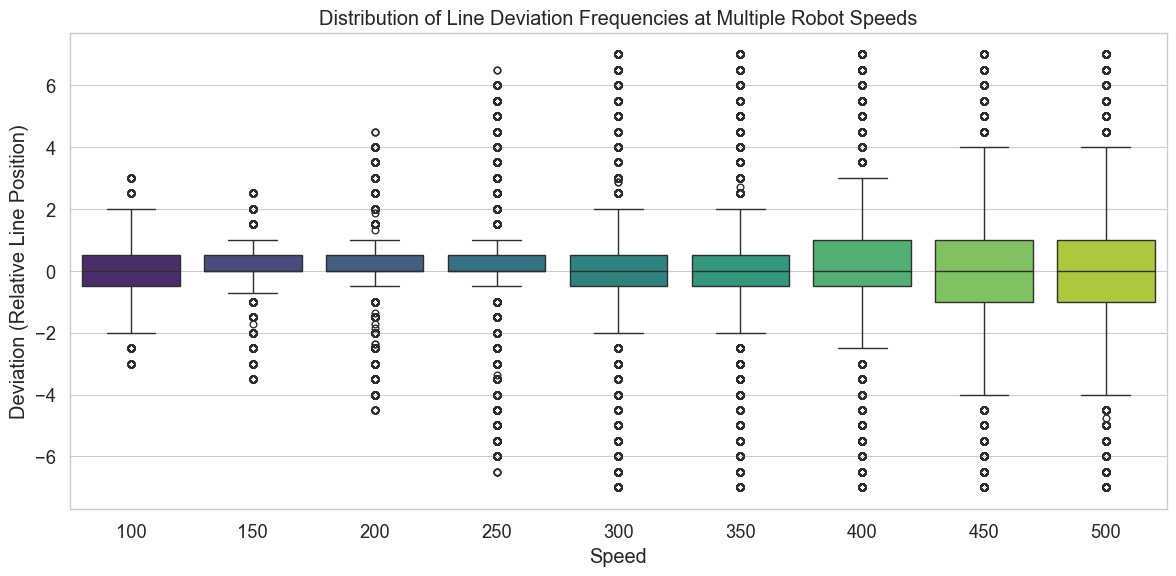

Negative deviation indicates the line is to the left of center (robot veering left), positive deviation indicates the line is to the right (robot veering right).


In [218]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='speed', y='deviation', data=df, palette='viridis')
plt.title('Distribution of Line Deviation Frequencies at Multiple Robot Speeds')
plt.xlabel('Speed')
plt.ylabel('Deviation (Relative Line Position)')
plt.tight_layout()
plt.show()
print("Negative deviation indicates the line is to the left of center (robot veering left), positive deviation indicates the line is to the right (robot veering right).")

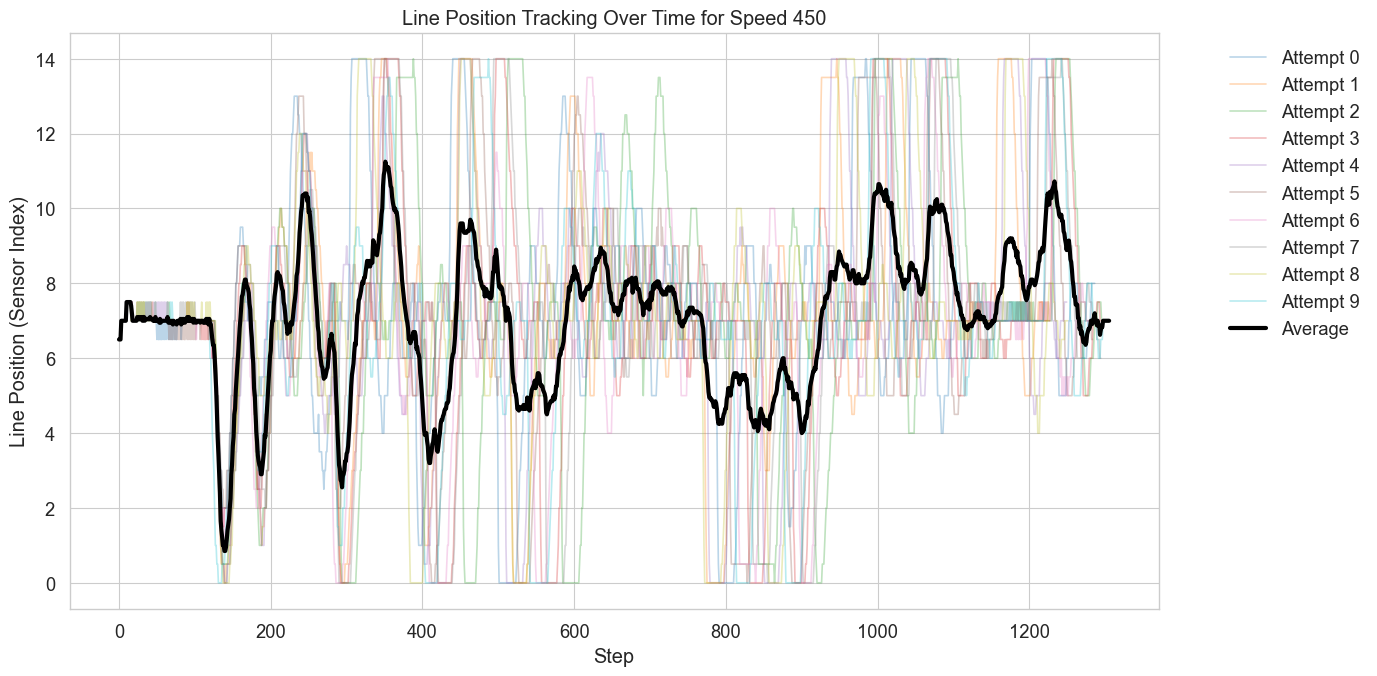

In [174]:
# Time Series Visualization
plt.figure(figsize=(14, 7))

speed_450_df = df[df['speed'] == 450]  
attempt_ids = speed_450_df['attempt_id'].unique()

# Plot individual attempts
for attempt_id in attempt_ids:
    attempt_data = speed_450_df[speed_450_df['attempt_id'] == attempt_id]
    plt.plot(attempt_data['step'], attempt_data['line_position'],
             alpha=0.3, label=f'Attempt {attempt_id}')

# Calculate and plot average line position
average_line = speed_450_df.groupby('step')['line_position'].mean()
plt.plot(average_line.index, average_line.values,
         color='black', linewidth=3, label='Average')

plt.title('Line Position Tracking Over Time for Speed 450')
plt.xlabel('Step')
plt.ylabel('Line Position (Sensor Index)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'sensor0'),
  Text(0, 1.5, 'sensor1'),
  Text(0, 2.5, 'sensor2'),
  Text(0, 3.5, 'sensor3'),
  Text(0, 4.5, 'sensor4'),
  Text(0, 5.5, 'sensor5'),
  Text(0, 6.5, 'sensor6'),
  Text(0, 7.5, 'sensor7'),
  Text(0, 8.5, 'sensor8'),
  Text(0, 9.5, 'sensor9'),
  Text(0, 10.5, 'sensor10'),
  Text(0, 11.5, 'sensor11'),
  Text(0, 12.5, 'sensor12'),
  Text(0, 13.5, 'sensor13'),
  Text(0, 14.5, 'sensor14')])

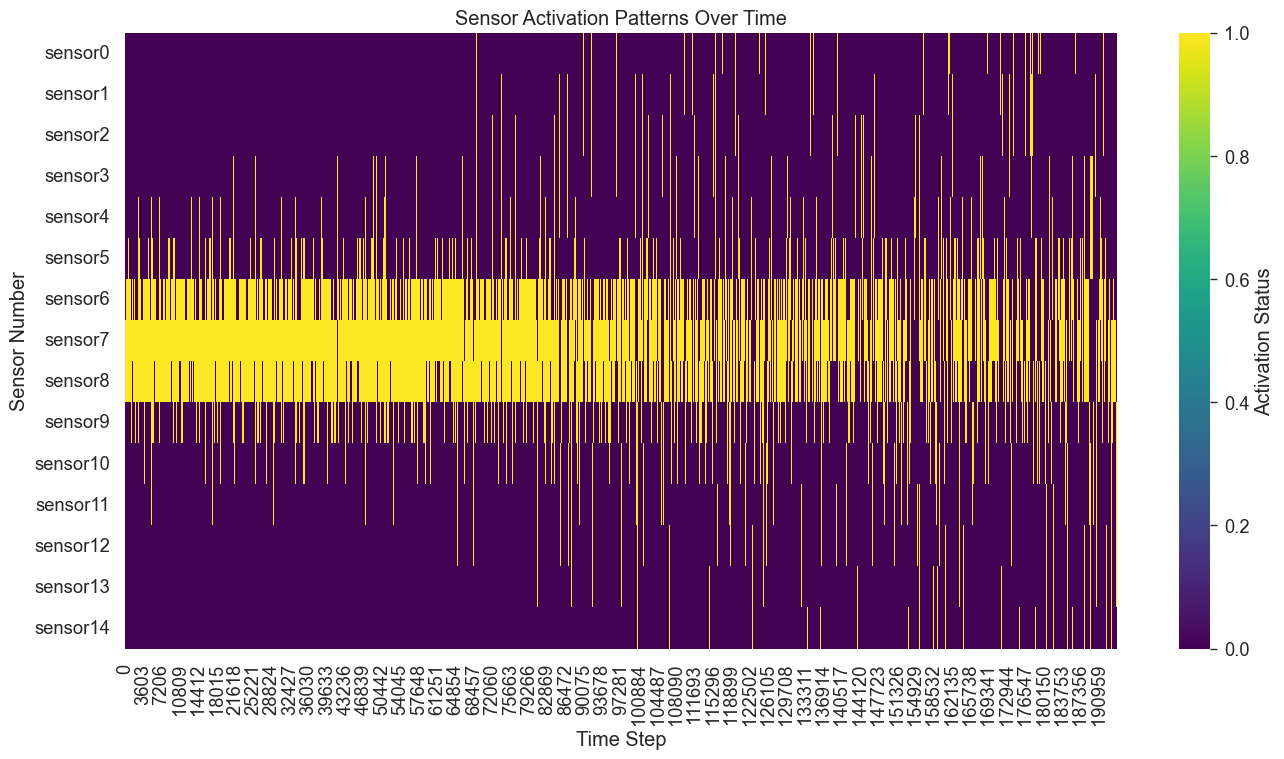

In [148]:
plt.figure(figsize=(16, 8))
sns.heatmap(df[sensor_columns].T, cmap='viridis', 
            cbar_kws={'label': 'Activation Status'})
plt.title('Sensor Activation Patterns Over Time')
plt.xlabel('Time Step')
plt.ylabel('Sensor Number')
plt.yticks(rotation=0)

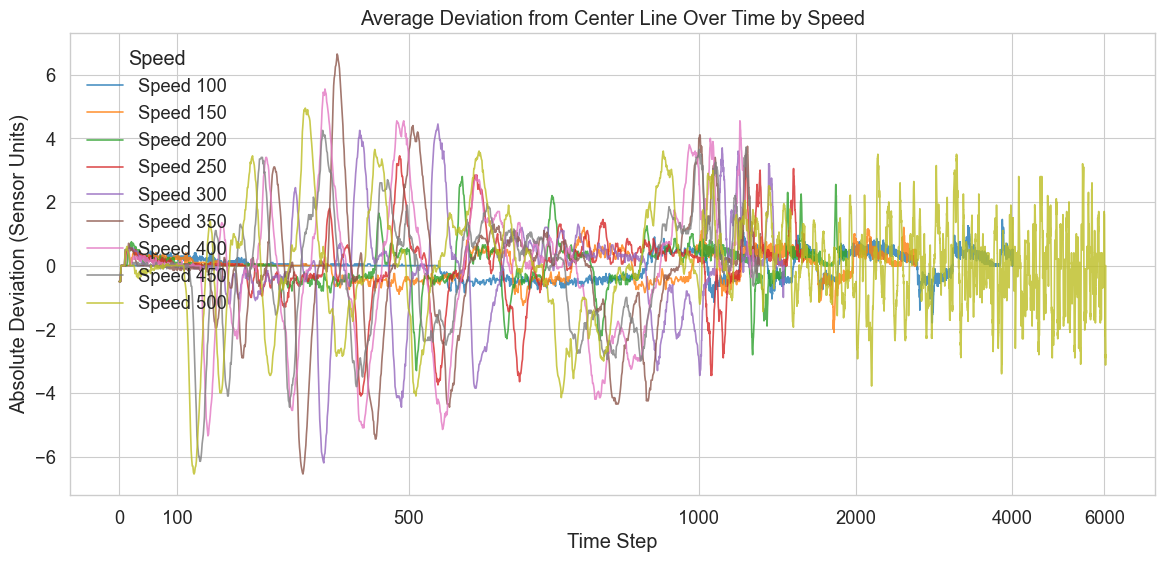

In [149]:
center_sensor = 7  # For 15 sensors, index 7 is the center
df['deviation'] = df['line_position'] - center_sensor

plt.figure(figsize=(14, 6))
for speed in df['speed'].unique():
    speed_data = df[df['speed'] == speed]
    avg_deviation = speed_data.groupby('step')['deviation'].mean()
    plt.plot(avg_deviation.index, avg_deviation.values, label=f'Speed {speed}', alpha=0.8)

plt.title('Average Deviation from Center Line Over Time by Speed')
plt.ylabel('Absolute Deviation (Sensor Units)')
plt.xscale('symlog', linthresh=1000)
plt.xlabel('Time Step')
plt.xticks([0, 100, 500, 1000, 2000, 4000, 6000], [0, 100, 500, 1000, 2000, 4000, 6000])
plt.legend(title='Speed')
plt.show()


Text(0.5, 1.0, 'Correlation Matrix of Sensors and Control Signals')

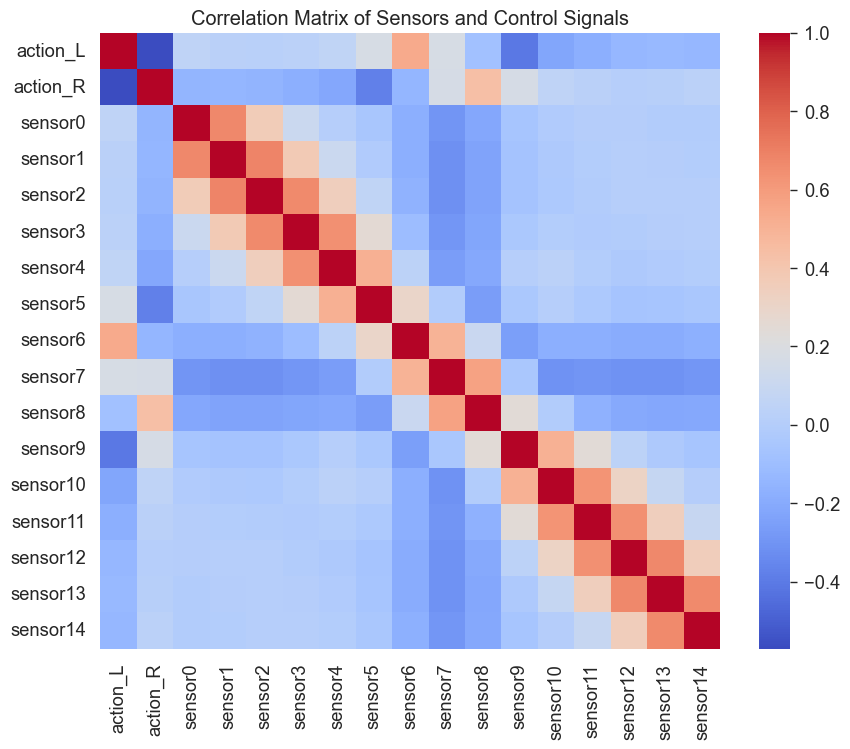

In [150]:
plt.figure(figsize=(10, 8))
corr_matrix = df[['action_L', 'action_R'] + sensor_columns].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Sensors and Control Signals')

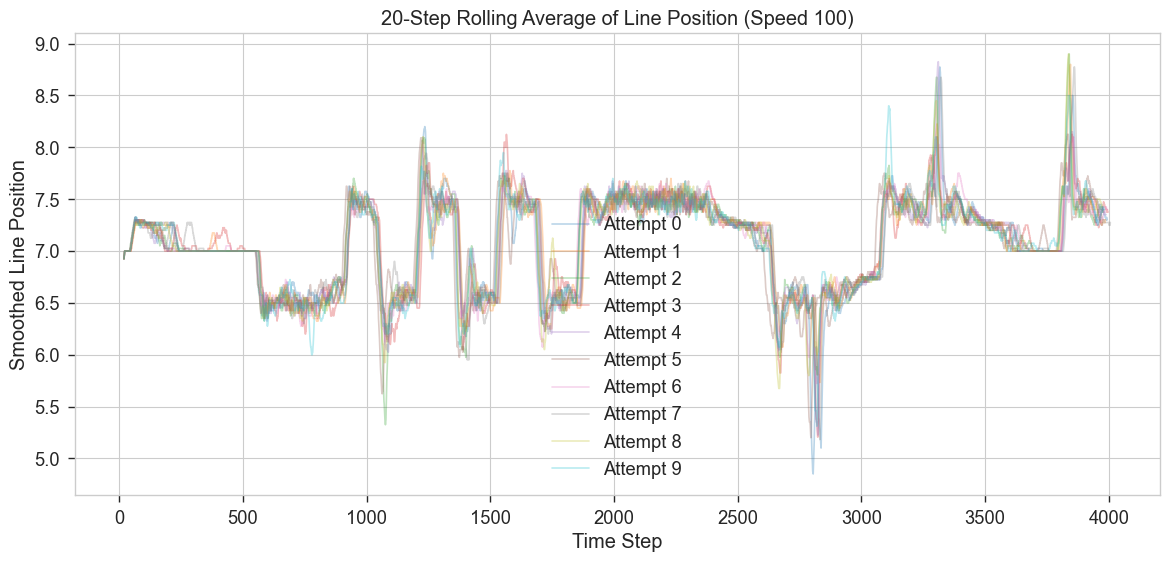

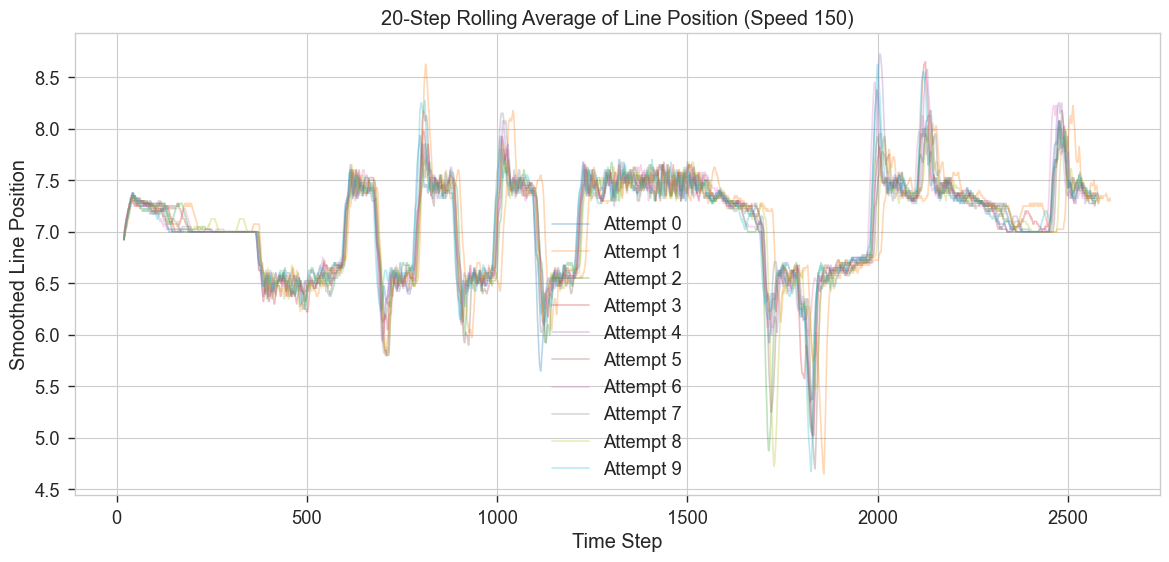

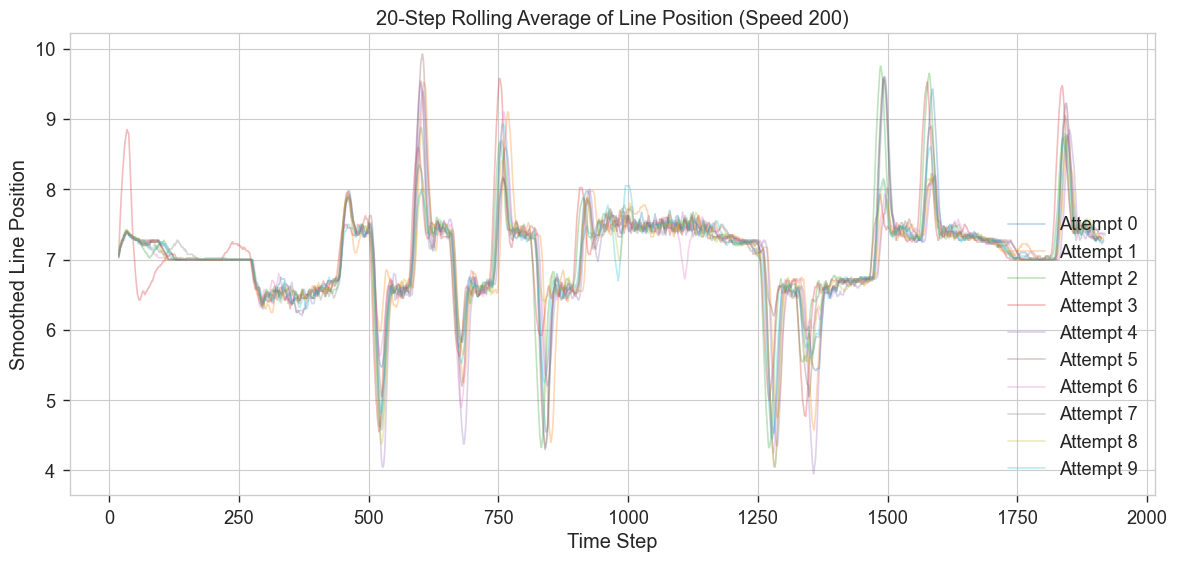

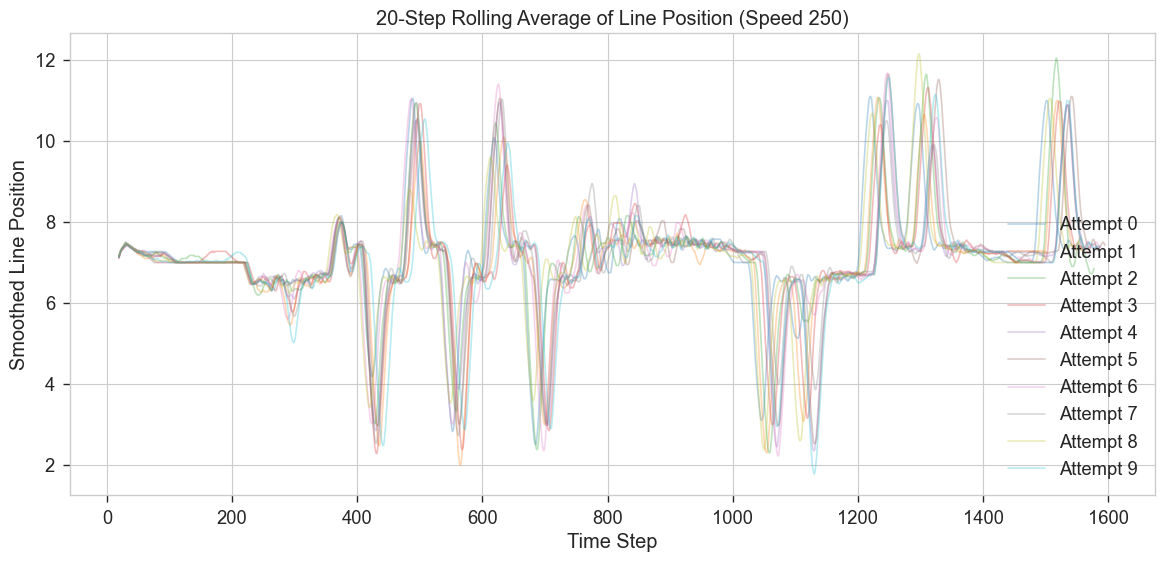

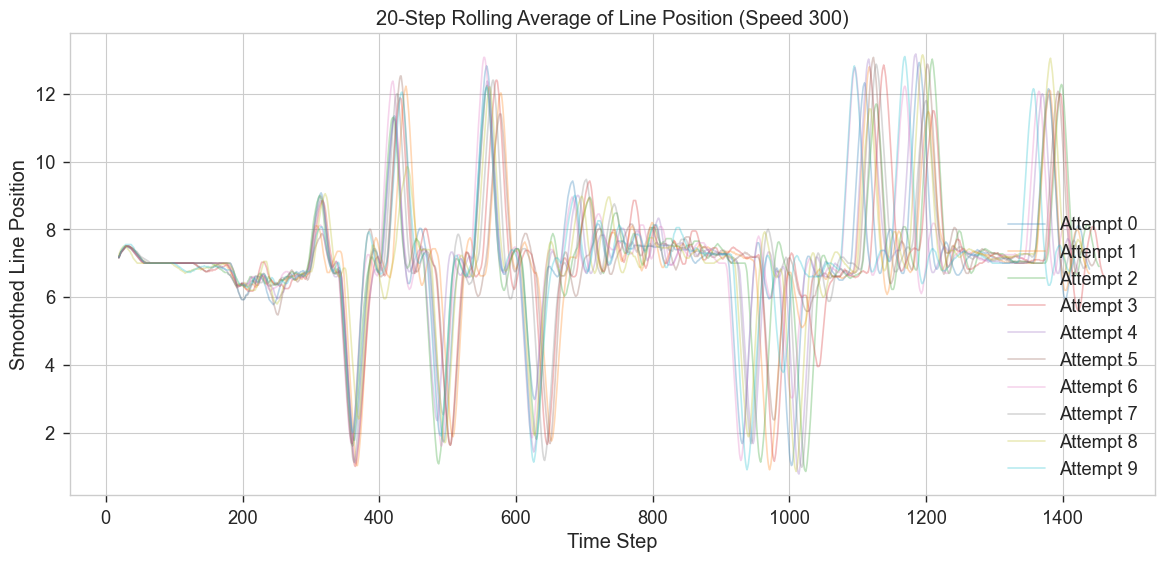

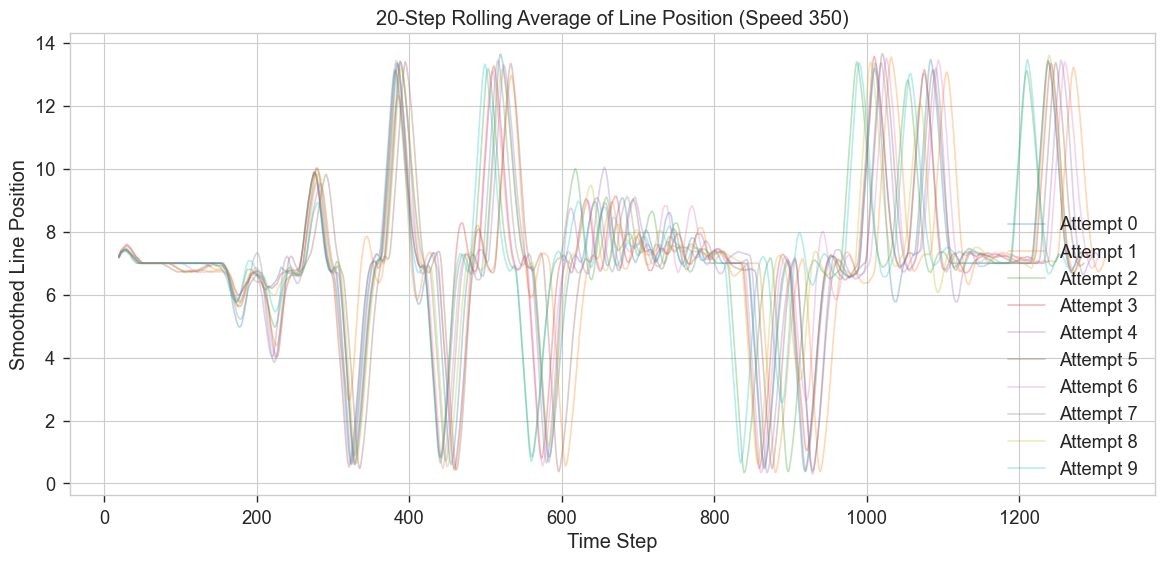

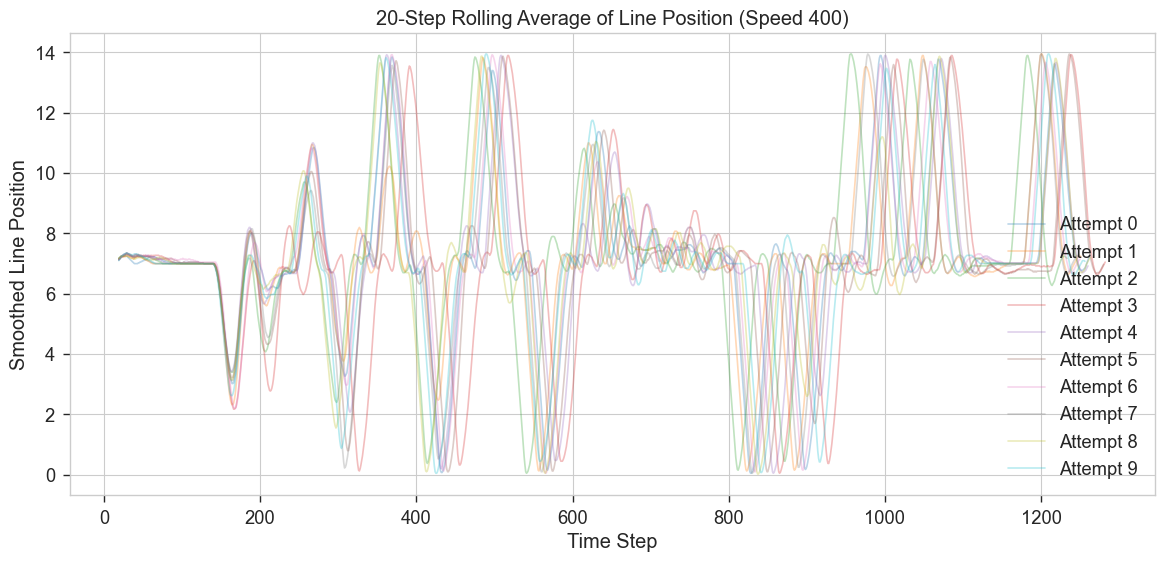

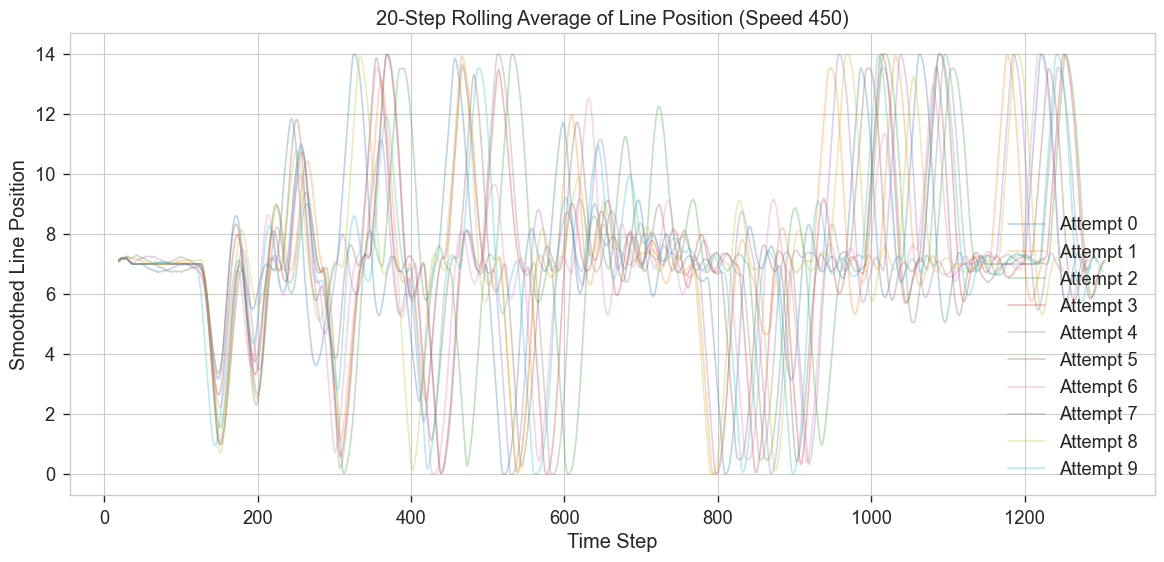

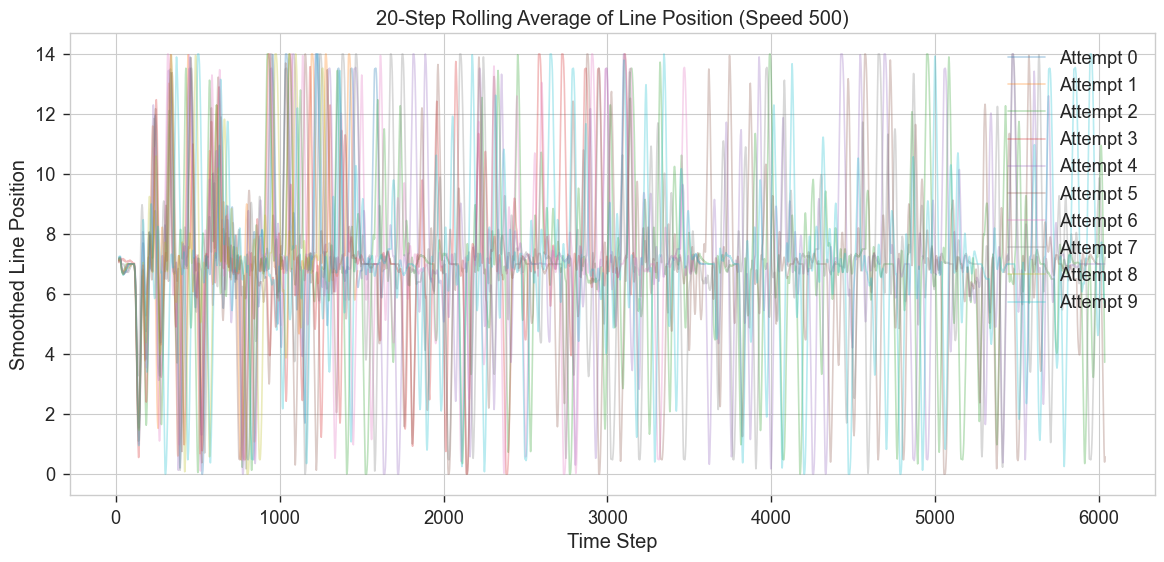

In [130]:
window_size = 20  # Use the existing variable if you want to change window size

for speed in df['speed'].unique():
    plt.figure(figsize=(14, 6))
    speed_data = df[df['speed'] == speed]
    for attempt_id in speed_data['attempt_id'].unique():
        attempt_data = speed_data[speed_data['attempt_id'] == attempt_id]
        rolling = attempt_data['line_position'].rolling(window=window_size).mean()
        plt.plot(attempt_data['step'], rolling, alpha=0.3, label=f'Attempt {attempt_id}')
    plt.title(f'{window_size}-Step Rolling Average of Line Position (Speed {speed})')
    plt.xlabel('Time Step')
    plt.ylabel('Smoothed Line Position')
    plt.legend()
    plt.show()

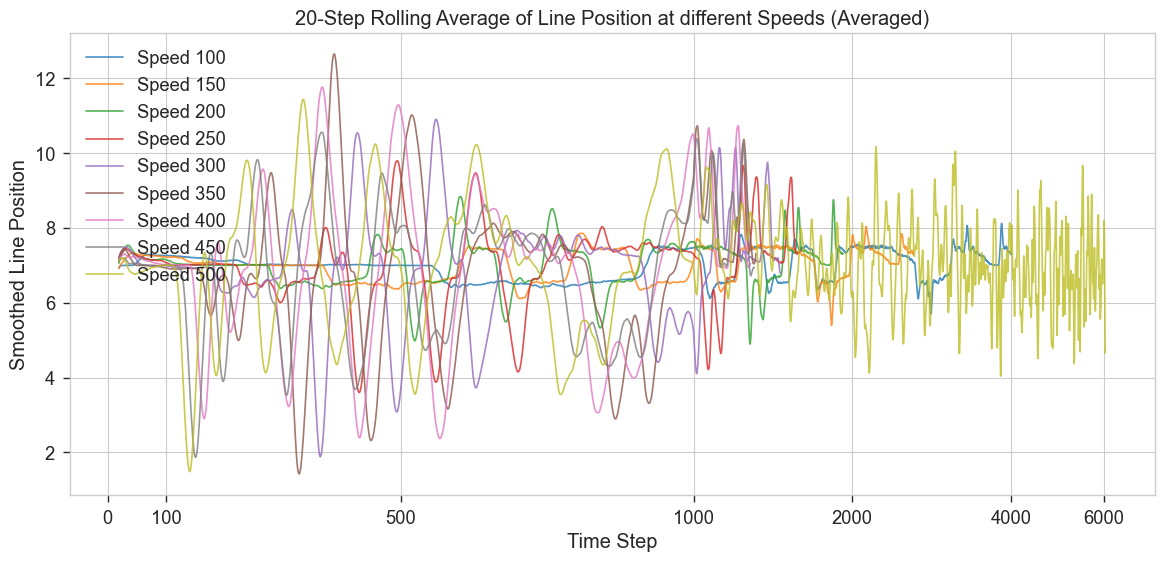

In [ ]:
plt.figure(figsize=(14, 6))
for speed in df['speed'].unique():
    speed_data = df[df['speed'] == speed]
    avg_rolling = speed_data.groupby('step')['line_position'].mean().rolling(window=window_size).mean()
    plt.plot(avg_rolling.index, avg_rolling.values, alpha=0.8, label=f'Speed {speed}')

plt.title(f'{window_size}-Step Rolling Average of Line Position at different Speeds (Averaged)')
plt.xscale('symlog', linthresh=1000)
plt.xlabel('Time Step')
plt.xticks([0, 100, 500, 1000, 2000, 4000, 6000], [0, 100, 500, 1000, 2000, 4000, 6000])
plt.ylabel('Smoothed Line Position')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
plt.show()


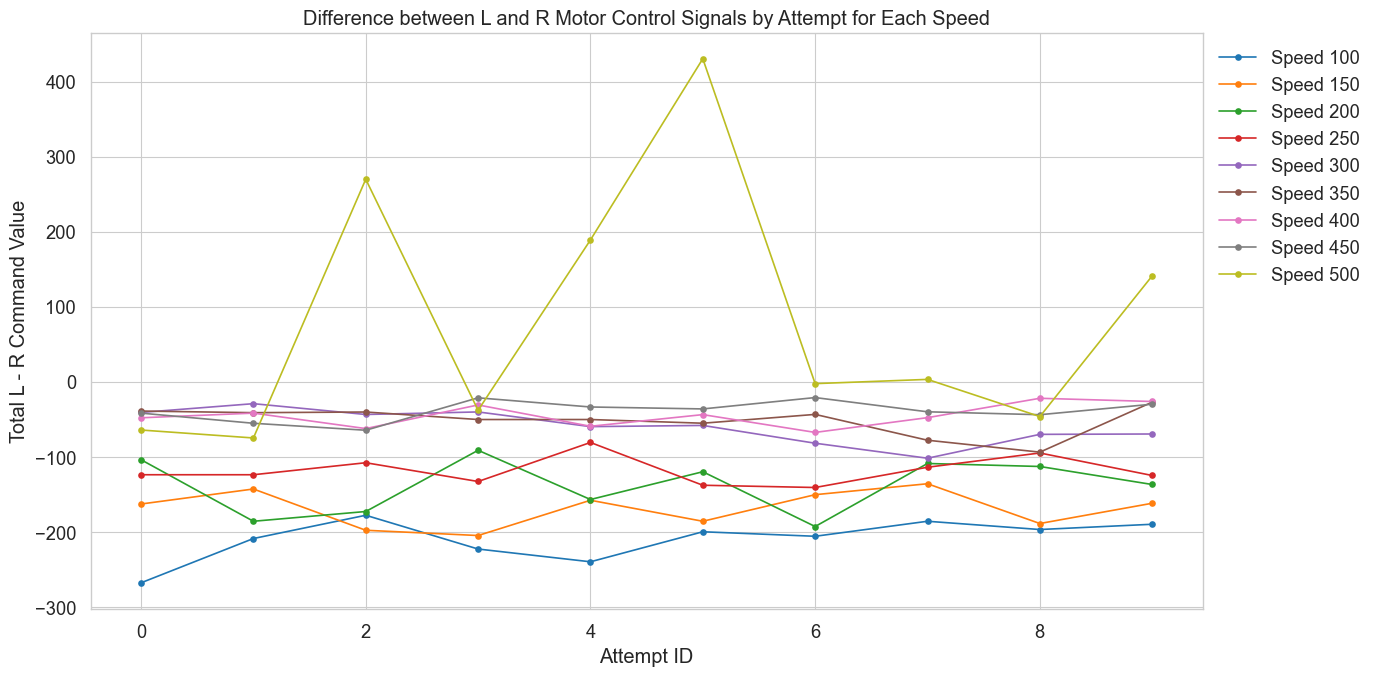

In [215]:
plt.figure(figsize=(14, 7))
for speed in df['speed'].unique():
    speed_data = df[df['speed'] == speed]
    actions_sum_speed = speed_data.groupby('attempt_id')[['action_L', 'action_R']].sum()
    diff = actions_sum_speed['action_L'] - actions_sum_speed['action_R']
    plt.plot(actions_sum_speed.index, diff, marker='o', label=f'Speed {speed}')

plt.title('Difference between L and R Motor Control Signals by Attempt for Each Speed')
plt.ylabel('Total L - R Command Value')
plt.xlabel('Attempt ID')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Average cumulative error for speed 100: 12.019059651562184
Average cumulative error for speed 150: 7.299772049398853
Average cumulative error for speed 200: -6.0872900132274275
Average cumulative error for speed 250: -55.43163675557935
Average cumulative error for speed 300: -68.37425503694293
Average cumulative error for speed 350: -90.95572633543523
Average cumulative error for speed 400: -71.53527013819294
Average cumulative error for speed 450: -130.83079225309314
Average cumulative error for speed 500: 159.47276557654766


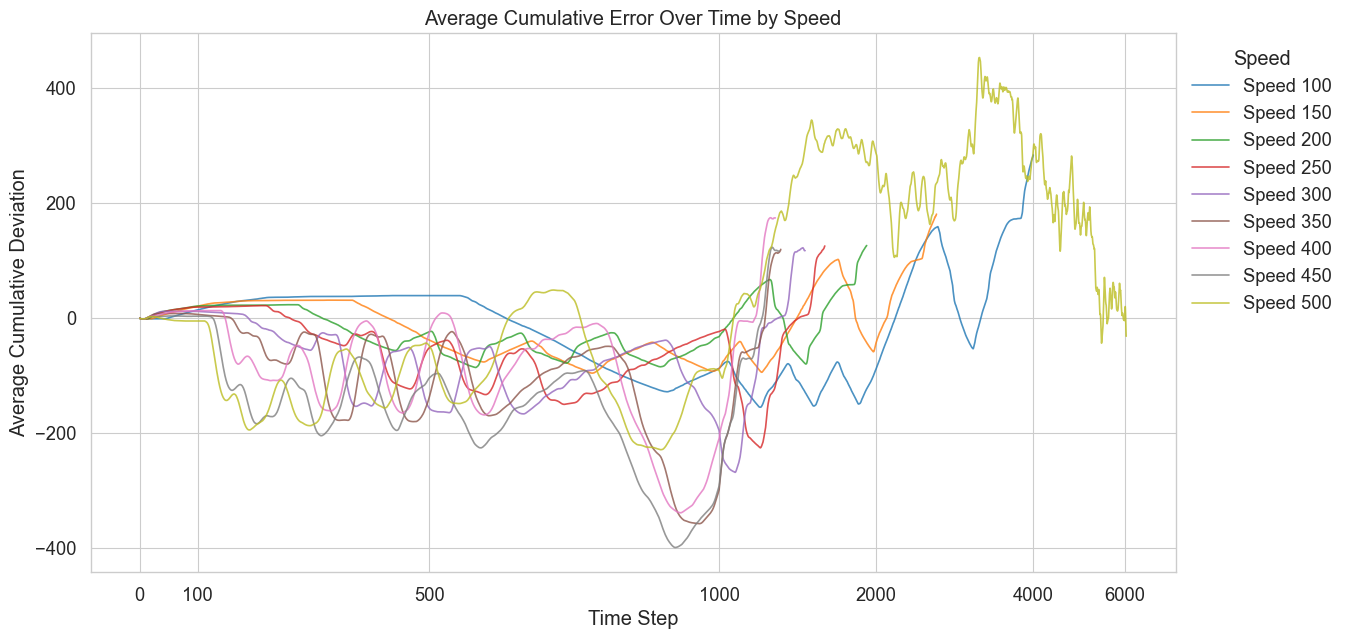

In [214]:
plt.figure(figsize=(14, 7))
for speed in df['speed'].unique():
    speed_data = df[df['speed'] == speed]
    # Compute average deviation per step across all attempts for this speed
    avg_deviation = speed_data.groupby('step')['deviation'].mean()
    avg_cumulative_error = avg_deviation.cumsum()
    plt.plot(avg_cumulative_error.index, avg_cumulative_error.values, label=f'Speed {speed}', alpha=0.8)
    print(f"Average cumulative error for speed {speed}: {avg_cumulative_error.mean()}")

plt.title('Average Cumulative Error Over Time by Speed')
plt.xscale('symlog', linthresh=1000)
plt.xlabel('Time Step')
plt.xticks([0, 100, 500, 1000, 2000, 4000, 6000], [0, 100, 500, 1000, 2000, 4000, 6000])
plt.ylabel('Average Cumulative Deviation')
plt.legend(title='Speed', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()


In [213]:
results = []

for speed in df['speed'].unique():
    print(f"Processing speed: {speed}")
    speed_data = df[df['speed'] == speed]
    attempts = []

    for attempt in speed_data['attempt_id'].unique():
        attempt_data = speed_data[speed_data['attempt_id'] == attempt]
        total_error = attempt_data['deviation'].sum()
        rmse = np.sqrt(np.mean(np.square(attempt_data['deviation'])))
        duration = attempt_data['step'].max() / 60

        attempts.append({
            'Total Error': total_error,
            'RMSE': rmse,
            'Time': duration
        })
    

    attempts_df = pd.DataFrame(attempts)

    std_total_error = speed_data['deviation'].std()
    std_rmse = np.std(np.sqrt(np.square(speed_data['deviation'])))
    std_duration = attempts_df['Time'].std()
    
    results.append({
        'Speed': speed,
        'Avg Total Error': f"{attempts_df['Total Error'].mean():.3f} (±{std_total_error:.3f})",
        'Avg RMSE': f"{attempts_df['RMSE'].mean():.3f} (±{std_rmse:.3f})",
        'Avg Time (s)': f"{attempts_df['Time'].mean():.3f} (±{std_duration:.3f})",
        'Min Time (s)': f"{attempts_df['Time'].min():.3f}"
    })

metrics_df = pd.DataFrame(results)
print("Average Metrics Per Speed:\n")
print(metrics_df.to_string(index=False))
speed_data


Processing speed: 100
Processing speed: 150
Processing speed: 200
Processing speed: 250
Processing speed: 300
Processing speed: 350
Processing speed: 400
Processing speed: 450
Processing speed: 500
Average Metrics Per Speed:

 Speed  Avg Total Error       Avg RMSE     Avg Time (s) Min Time (s)
   100 277.492 (±0.541) 0.546 (±0.381)  66.455 (±0.175)       66.217
   150 169.208 (±0.600) 0.604 (±0.442)  42.998 (±0.214)       42.800
   200 123.987 (±0.851) 0.852 (±0.685)  31.865 (±0.071)       31.750
   250 117.112 (±1.599) 1.599 (±1.340)  26.277 (±0.240)       25.850
   300 119.284 (±2.183) 2.184 (±1.810)  23.953 (±0.238)       23.633
   350 109.271 (±2.748) 2.748 (±2.228)  21.440 (±0.310)       20.867
   400 171.900 (±3.045) 3.047 (±2.400)  20.973 (±0.246)       20.550
   450 106.864 (±3.167) 3.165 (±2.400)  21.300 (±0.452)       20.433
   500 152.081 (±3.173) 3.214 (±2.367) 68.818 (±35.415)       21.867


speed  attempt_id  step  sensor0  sensor1  sensor2  sensor3  sensor4  \
153237    500           0     0      0.0      0.0      0.0      0.0      0.0   
153238    500           0     1      0.0      0.0      0.0      0.0      0.0   
153239    500           0     2      0.0      0.0      0.0      0.0      0.0   
153240    500           0     3      0.0      0.0      0.0      0.0      0.0   
153241    500           0     4      0.0      0.0      0.0      0.0      0.0   
...       ...         ...   ...      ...      ...      ...      ...      ...   
194533    500           9  6028      0.0      0.0      0.0      0.0      0.0   
194534    500           9  6029      0.0      0.0      0.0      1.0      1.0   
194535    500           9  6030      0.0      0.0      0.0      1.0      1.0   
194536    500           9  6031      0.0      0.0      1.0      1.0      1.0   
194537    500           9  6032      0.0      0.0      1.0      1.0      1.0   

        sensor5  sensor6  ...  sensor9  sensor10  sensor11  sensor12  \
153237      0.0      1.0  ...      0.0       0.0       0.0       0.0   
153238      0.0      1.0  ...      0.0       0.0       0.0       0.0   
153239      0.0      1.0  ...      0.0       0.0       0.0       0.0   
153240      0.0      1.0  ...      0.0       0.0       0.0       0.0   
153241      0.0      1.0  ...      0.0       0.0       0.0       0.0   
...         ...      ...  ...      ...       ...       ...       ...   
194533      1.0      1.0  ...      0.0       0.0       0.0       0.0   
194534      1.0      1.0  ...      0.0       0.0       0.0       0.0   
194535      1.0      1.0  ...      0.0       0.0       0.0       0.0   
194536      1.0      1.0  ...      1.0       0.0       0.0       0.0   
194537      1.0      1.0  ...      1.0       0.0       0.0       0.0   

        sensor13  sensor14  action_L  action_R  line_position  deviation  
153237       0.0       0.0       1.0      -1.0            6.5       -0.5  
153238       0.0       0.0       1.0       0.0            6.5       -0.5  
153239       0.0       0.0       1.0       0.0            6.5       -0.5  
153240       0.0       0.0      -1.0       1.0            7.0        0.0  
153241       0.0       0.0       1.0       1.0            7.0        0.0  
...          ...       ...       ...       ...            ...        ...  
194533       0.0       0.0       1.0       0.0            6.5       -0.5  
194534       0.0       0.0       1.0      -1.0            5.5       -1.5  
194535       0.0       0.0       1.0      -1.0            5.5       -1.5  
194536       0.0       0.0       1.0      -1.0            5.5       -1.5  
194537       0.0       0.0       1.0      -1.0            5.5       -1.5  

[41301 rows x 22 columns]

In [137]:
attempt_time.max() / 60  # Maximum step for speed 500 in minutes

1.6769444444444443

In [205]:
attempt_time.groupby(level='speed').min() / 60  # Maximum step for each speed in minutes

speed
100    1.103611
150    0.713333
200    0.529167
250    0.430833
300    0.393889
350    0.347778
400    0.342500
450    0.340556
500    0.364444
Name: step, dtype: float64